# Packages

In [0]:
import cv2
import os
import tarfile
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Flatten,\
Dense, Reshape, Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.nn import conv2d_transpose

# Dataset

In [109]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tar"
# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tar"
# workaround for https://github.com/tqdm/tqdm/issues/481
tqdm.monitor_interval = 0


class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) *\
        self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <=\
        self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.notebook.tqdm(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        print('using simple tqdm')
        return SimpleTqdm(*args, **kwargs)


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs.columns = list(df_attrs.columns)[1:] + ["NaN"]
    df_attrs = df_attrs.drop("NaN", axis=1)
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id,
                                      'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs,
                                on=('person', 'imagenum')).\
                                drop(["person", "imagenum"],
                                axis=1)

    return all_photos, all_attrs

# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


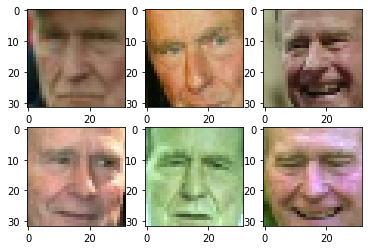

In [114]:
def show_data(X):
    for i in range(6):
        plt.subplot(2,3,i+1)
        x = X[i]
        plt.imshow(np.clip(x + 0.5, 0, 1))
    print("X shape:", X.shape)
    print("attr shape:", attr.shape)

show_data(X)

# Autoencoder architecture

## PCA

In [47]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    clear_session()
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    # Flatten image to vector
    encoder.add(Flatten())
    # Actual encoder
    encoder.add(Dense(code_size))

    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    # Actual decoder, height*width*3 units
    decoder.add(Dense(np.prod(img_shape)))
    # Un-flatten
    decoder.add(Reshape(img_shape))
    
    return encoder, decoder

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                verbose=1)

Epoch 1/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0146 - val_loss: 0.0000e+00
Epoch 2/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0092 - val_loss: 0.0000e+00
Epoch 3/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0077 - val_loss: 0.0000e+00
Epoch 4/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 5/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 6/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 7/15
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 8/15
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 9/15
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 10/15
370/370 [==============================] - 2s 6ms/st

PCA MSE: 0.006527658551931381


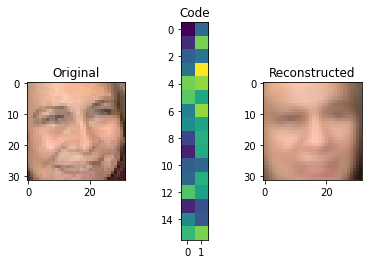

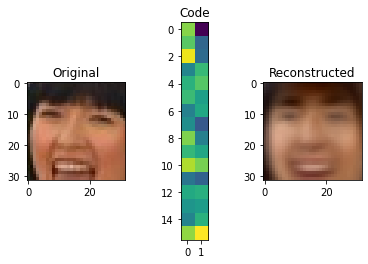

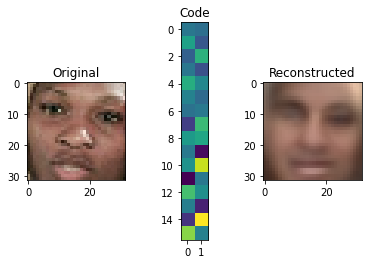

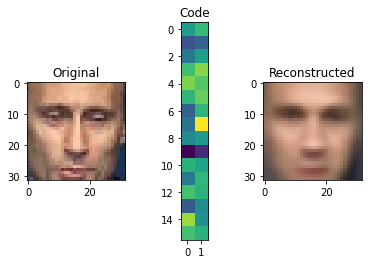

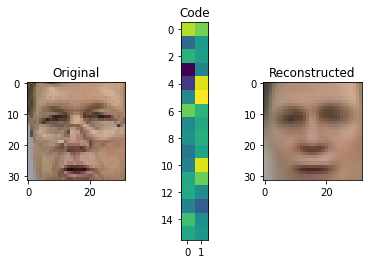

In [49]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] is the same as img[np.newaxis, :]
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

## Convolutional autoencoder


In [115]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".\
          format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).\
    reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).\
    reshape((filter_size, filter_size, 1, 1))

    clear_session()

    
    conv = conv2d_transpose(x, f, 
                            output_shape=(1, img_size * 2, img_size * 2, 1), 
                            strides=[1, 2, 2, 1], 
                            padding='SAME')

    #result = s.run(conv)
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(conv[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]], shape=(8, 8), dtype=float32)
Transpose convolution tes

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """
    PCA's deeper brother. See instructions above. Use `code_size` in
    layer definitions.
    """
    H,W,C = img_shape
    clear_session()
    # encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Conv2D(filters=32, kernel_size=(3,3),
                       padding="same", activation='elu'))
    encoder.add(MaxPooling2D())
    encoder.add(Conv2D(filters=64, kernel_size=(3,3),
                       padding="same", activation='elu'))
    encoder.add(MaxPooling2D())
    encoder.add(Conv2D(filters=128, kernel_size=(3,3),
                       padding="same", activation='elu'))
    encoder.add(MaxPooling2D())
    encoder.add(Conv2D(filters=256, kernel_size=(3,3),
                       padding="same", activation='elu'))
    encoder.add(MaxPooling2D())
    # flatten image to vector
    encoder.add(Flatten())
    # actual encoder
    encoder.add(Dense(code_size, activation='elu'))

    # decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    # actual decoder, height*width*3 units
    decoder.add(Dense(np.prod((2, 2, 256))))
    # un-flatten
    decoder.add(Reshape((2, 2, 256)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2,
                                activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2,
                                activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2,
                                activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2,
                                activation=None, padding='same'))
    
    return encoder, decoder

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

In [69]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),\
    "encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,\
    "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,\
    "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,\
    "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size,\
        "Encoder layer %s is smaller than bottleneck (%i units)"%\
        (layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [70]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [74]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                verbose=1)

Epoch 1/25
370/370 [==============================] - 59s 158ms/step - loss: 0.0140 - val_loss: 0.0000e+00
Epoch 2/25
370/370 [==============================] - 58s 156ms/step - loss: 0.0086 - val_loss: 0.0000e+00
Epoch 3/25
370/370 [==============================] - 59s 160ms/step - loss: 0.0076 - val_loss: 0.0000e+00
Epoch 4/25
370/370 [==============================] - 59s 159ms/step - loss: 0.0072 - val_loss: 0.0000e+00
Epoch 5/25
370/370 [==============================] - 60s 161ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 6/25
370/370 [==============================] - 60s 163ms/step - loss: 0.0069 - val_loss: 0.0000e+00
Epoch 7/25
370/370 [==============================] - 60s 163ms/step - loss: 0.0069 - val_loss: 0.0000e+00
Epoch 8/25
370/370 [==============================] - 60s 163ms/step - loss: 0.0068 - val_loss: 0.0000e+00
Epoch 9/25
370/370 [==============================] - 62s 167ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 10/25
370/370 [================

Convolutional autoencoder MSE: 0.005864742211997509


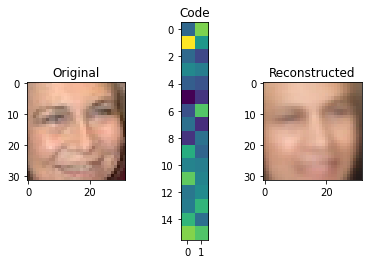

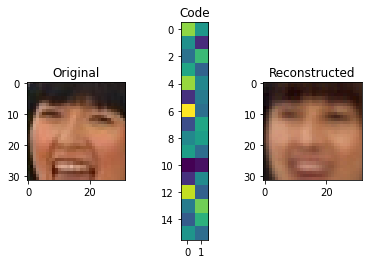

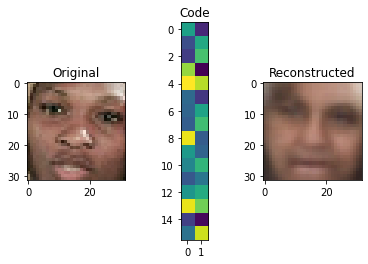

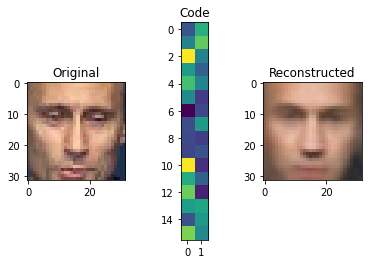

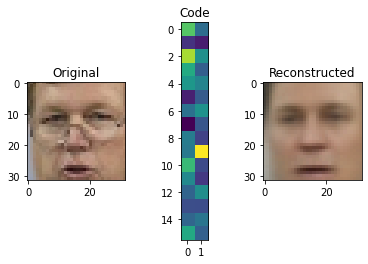

In [75]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [77]:
# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005864742211997509
0.005864742211997509


## Denoising Autoencoder

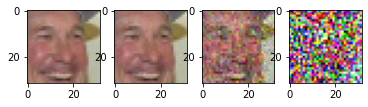

In [80]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(X.mean(), sigma, X.shape)
    return X + noise

# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01,\
"Standard deviation does not match it's required value. "
"Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() -
           X_train[:100].mean()) < 0.01,\
           "Mean has changed. Please add zero-mean noise"

# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Training will take **1 hour**.

In [81]:
# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,),\
"encoder must output a code of required size"

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...
Epoch 2/25, Generating corrupted samples...
Epoch 3/25, Generating corrupted samples...
Epoch 4/25, Generating corrupted samples...
Epoch 5/25, Generating corrupted samples...
Epoch 6/25, Generating corrupted samples...
Epoch 7/25, Generating corrupted samples...
Epoch 8/25, Generating corrupted samples...
Epoch 9/25, Generating corrupted samples...
Epoch 10/25, Generating corrupted samples...
Epoch 11/25, Generating corrupted samples...
Epoch 12/25, Generating corrupted samples...
Epoch 13/25, Generating corrupted samples...
Epoch 14/25, Generating corrupted samples...
Epoch 15/25, Generating corrupted samples...
Epoch 16/25, Generating corrupted samples...
Epoch 17/25, Generating corrupted samples...
Epoch 18/25, Generating corrupted samples...
Epoch 19/25, Generating corrupted samples...
Epoch 20/25, Generating corrupted samples...
Epoch 21/25, Generating corrupted samples...
Epoch 22/25, Generating corrupted samples...
Epoch 23/25, Genera

Denoising MSE: 0.0029486105777323246


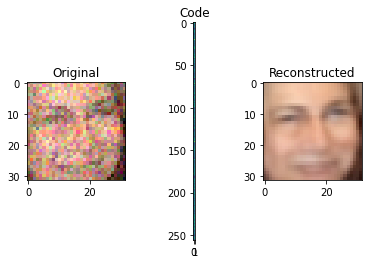

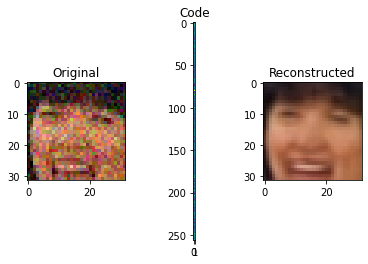

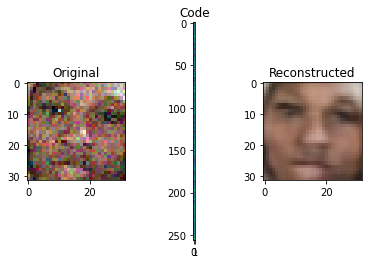

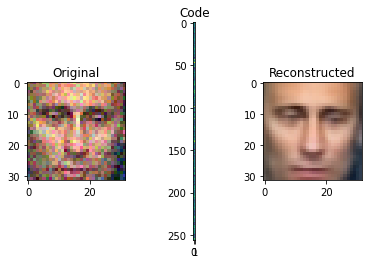

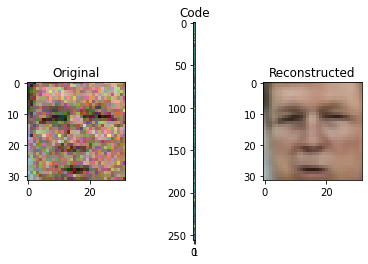

In [82]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Image Retrieval with Autoencoders

In [93]:
# restore trained encoder weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

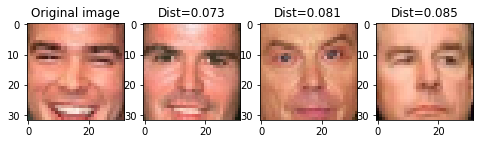

In [88]:
# smiles
show_similar(X_test[247])

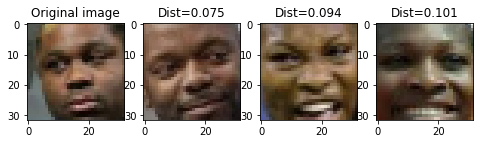

In [89]:
# ethnicity
show_similar(X_test[56])

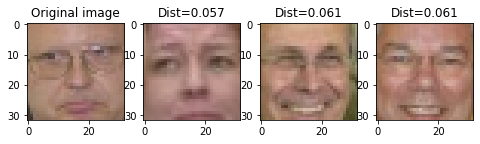

In [90]:
# glasses
show_similar(X_test[63])

# Cheap image morphing


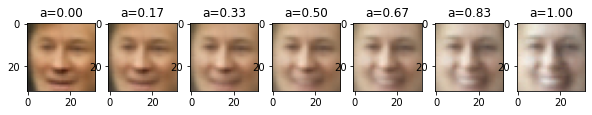

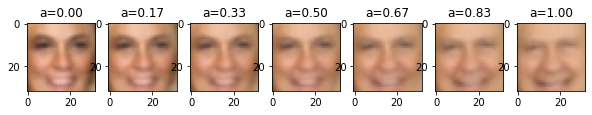

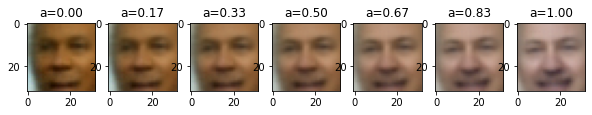

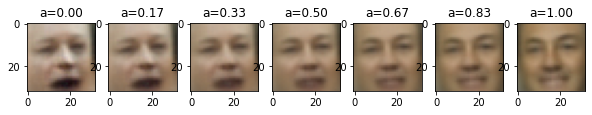

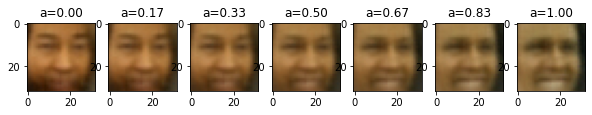

In [92]:
# restore trained encoder weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()